In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import datetime
import numpy
import modeltools.grid
import matplotlib.pyplot
import modeltools.hycom
import modeltools.hycom.io
import modeltools.tools
import modeltools.forcing.atmosphere
import modeltools.tools
import pylab
import time
import random
from mpl_toolkits.basemap import Basemap, shiftgrid

def plot_data(lo,la,data) :
    pylab.figure()
    m = Basemap(resolution='c',projection='mill',lat_0=90.,lon_0=0.)
    x,y=m(lo,la)
    parallels = numpy.arange(-80.,90,20.)
    meridians = numpy.arange(0.,360.,20.)
    m.pcolormesh(x,y,data)
    m.colorbar()
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    m.drawcoastlines()
    return

pylab.rcParams['figure.figsize'] = 12, 8

# Define (or read) grid
grid1=modeltools.grid.Proj4Grid("+proj=stere  +lon_0=-45 +lat_0=90 +lat_ts=80 +ellps=sphere",
                          -89.5,45.5,20000,20000,400,300)
mlon,mlat=grid1.pgrid()

# parse blkdat to get yearflag
blkd = modeltools.hycom.BlkdatParser("blkdat.input")
yrflag = blkd["yrflag"]
wndflg = blkd["wndflg"]
lwflag  = blkd["lwflag"]

print "wndflg=",wndflg

# Forcing metadata from xml file
#af=modeltools.forcing.atmosphere.AtmosphericForcing("era-interim.xml","era-interim")
#start=datetime.datetime(1991,6,3,12,0,0)
#end=datetime.datetime(1991,6,10,12,0,0)

af=modeltools.forcing.atmosphere.AtmosphericForcing("ec_op.xml","ec_op")
start=datetime.datetime(2015,11,11,12,0,0)
end=start
#end=datetime.datetime(2015,11,13,12,0,0)

timestep=af.timestep
timestepday=timestep.days+timestep.seconds/86400.

# Open output files. Dict uses "known name" when mapping to file object
ffiles={}
for k,vname in modeltools.hycom.atmosphere_variable_names.items() :
    if k in af.known_names :
        ffiles[k]=modeltools.hycom.io.ABFileForcing("forcing.%s"%vname,"w",idm=grid1.Nx, jdm=grid1.Ny,
                                                    cline1="ERA Interim",cline2=vname)


# Main loop 
ffiles={}
dt = start
while dt <= end :
    
    print "Reading at ",dt
    # Read variables
    af.get_timestep(dt)
    #af.get_coords(dt,varnames=known_names)
    #af.get_grid(dt,varnames=known_names)

#    if dt == start :
#        if "ssrd" in af.known_names :
#            lo,la=af["ssrd"].grid
#            plot_data(lo,la,af["ssrd"].data)
    
    # Estimate dependent variable on native grid
    if wndflg in [1,2,3] :
        af.calculate_windstress()
        af.calculate_windspeed()
        af.calculate_ustar()
    af.calculate_vapmix()
    af.calculate_ssrd()

    # radflx is downwelling longwave radiation
    if lwflag == -1 :
        af.calculate_tsrd()
    else :
        raise ValueError,"TODO: lwflag<>-1 not supported"


    # Open output files. Dict uses "known name" when mapping to file object
    if dt == start :
        for k,vname in modeltools.hycom.atmosphere_variable_names.items() :
            if k in af.known_names :
                ffiles[k]=modeltools.hycom.io.ABFileForcing("forcing.%s"%vname,"w",idm=grid1.Nx, jdm=grid1.Ny,
                                                            cline1="ERA Interim",cline2=vname)
                
    # Interpolation of all fields
    newfld={}
    for kn in [elem for elem in af.known_names if elem in ffiles.keys()] :
            
        # NAme used by hycom
        vname=modeltools.hycom.atmosphere_variable_names[kn]

        # Read fields using known names
        lo,la=af[kn].coords
        fld=af[kn].data

        fi=modeltools.tools.FieldInterpolatorBilinear(lo,la,fld,mlon,mlat)
        newfld[kn]=fi.interpolate(fld)
        #fi=modeltools.tools.interpolation.FieldInterpolatorRectBivariateSpline(lo,la,fld,mlon,mlat)
        #newfld=fi.interpolate(fld)
        
    # Do rotation of u and v components if this the first component of a vector field
    for kn in af.known_names :
        if kn in modeltools.hycom.atmosphere_variable_vectors.keys() :
            knu,knv = modeltools.hycom.atmosphere_variable_vectors[kn]
            ur,vr=modeltools.tools.rotate_vector(newfld[knu],newfld[knv],mlon,mlat)
            newfld[knu]=ur
            newfld[knv]=vr

        
    # Loop over open files 
    for kn in ffiles.keys() :

        # Write to forcing file
        newdt=af[kn].time
        ord_day,hour=modeltools.hycom.datetime_to_ordinal(newdt,yrflag)
        dtime=modeltools.hycom.dayfor(newdt.year,ord_day,hour,yrflag)
        print ord_day,hour,dtime
        ffiles[kn].writefield(newfld[kn],newfld[kn],vname,dtime,timestepday)
    
    # Increase time
    dt = dt + timestep
    

            
for kn in ffiles.keys() :
    ffiles[kn].close()
af=[]





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
wndflg= 4
Reading at 

INFO:root:Setting calendar from explicit coordinate properties for variable time
INFO:root:Setting units from explicit coordinate properties for variable lat
INFO:root:Setting units from explicit coordinate properties for variable lon
INFO:root:Setting units from explicit coordinate properties for variable lat
INFO:root:Setting units from explicit coordinate properties for variable lon
INFO:root:Reading name                   2t, varname=                 T2M
INFO:root:Setting calendar from explicit coordinate properties for variable time
INFO:root:Setting units from explicit coordinate properties for variable lat
INFO:root:Setting units from explicit coordinate properties for variable lon
INFO:root:Setting units from explicit coordinate properties for variable lat
INFO:root:Setting units from explicit coordinate properties for variable lon
INFO:root:Reading name                   2d, varname=                 D2M
INFO:root:Setting calendar from explicit coordinate properties for variabl

 2015-11-11 12:00:00
41.4174455551 89.8954421801
mlat.shape : (300, 400)
weight_lat : 0.546280138142
dlon       : -0.425895825762
dlat       : 0.238310582473
mlat       : 56.8878127287
theta1R    : 44.3113935101
theta2     : 134.312419933
315 12.0 41953.5
315 12.0 41953.5
315 12.0 41953.5
315 12.0 41953.5
315 12.0 41953.5
315 12.0 41953.5
315 12.0 41953.5


-26.9468460083 17.3700485229
-24.1180801392 19.5940704346
231.326461792 294.595367432
121.251174927 416.851074219
96842.359375 103059.4375
400 300
(300, 400)


<matplotlib.colorbar.Colorbar instance at 0x7f6c8b2ed518>

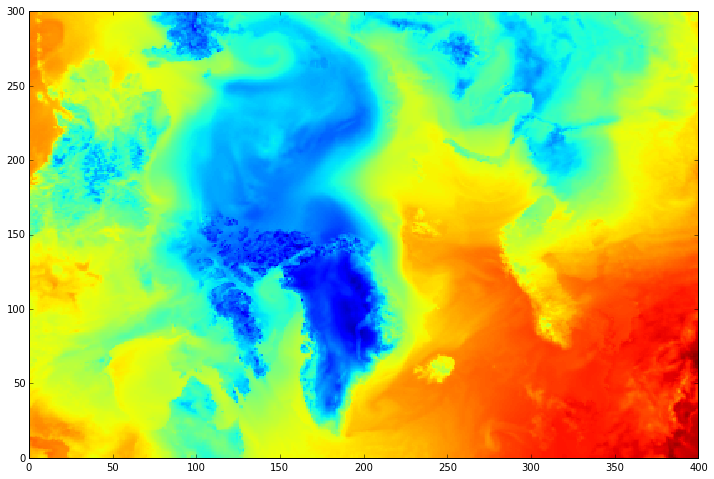

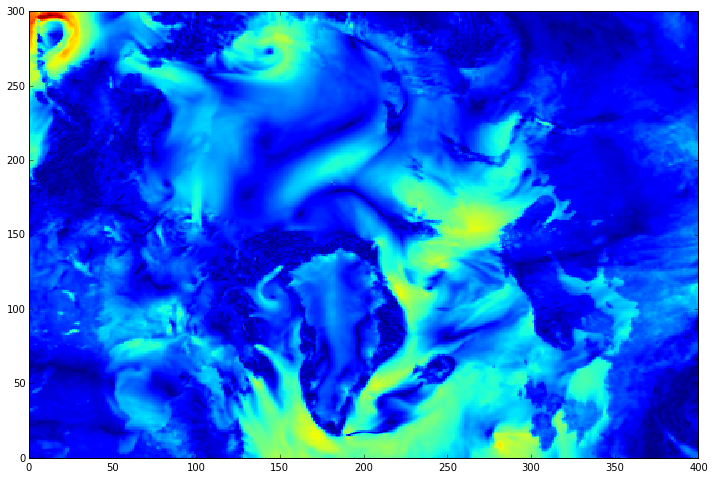

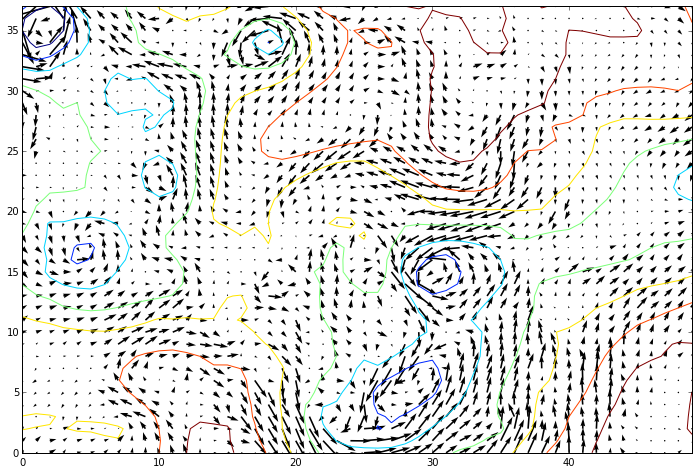

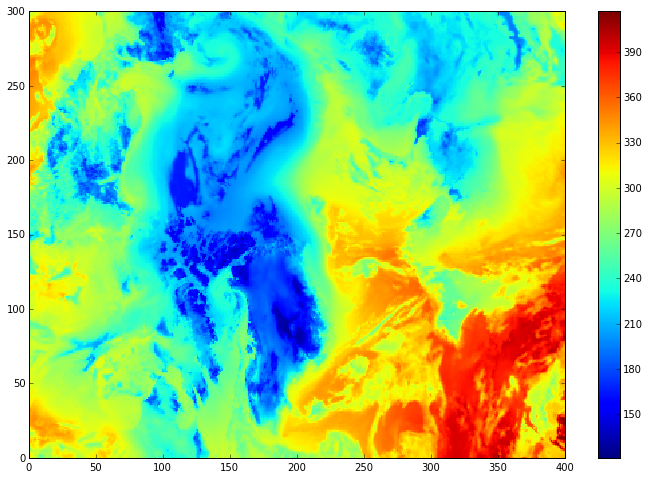

In [30]:


# Open 10 and 10v files
f10u=modeltools.hycom.io.ABFileForcing("forcing.wndewd","r")
f10v=modeltools.hycom.io.ABFileForcing("forcing.wndnwd","r")
f2t=modeltools.hycom.io.ABFileForcing("forcing.airtmp","r")
fmsl=modeltools.hycom.io.ABFileForcing("forcing.mslprs","r")
frad=modeltools.hycom.io.ABFileForcing("forcing.radflx","r")


u=f10u.readfield(0)
v=f10v.readfield(0)
t=f2t.readfield(0)
f=frad.readfield(0)

msl=fmsl.readfield(0)
print grid1.Nx,grid1.Ny
print u.shape

#pylab.quiver(u,v)
#pylab.show()
pylab.pcolor(t)
pylab.figure()
pylab.pcolor(numpy.sqrt(u**2+v**2))
pylab.figure()
pylab.quiver(u[::8,::8],v[::8,::8])
pylab.contour(msl[::8,::8])
pylab.figure()
pylab.pcolor(f)
pylab.colorbar()
